## Fáza 3 - strojové učenie
 Autor: Martin Katkovčin

**Načítanie potrebných knižníc**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate


import sklearn.metrics as sm
import graphviz 
import warnings
warnings.filterwarnings('ignore')

V minulej fáze sme si vybrali pár atribútov pre strojové učenie, ktoré mali najvyššie korelácie s atribútom 'indikátor' a taktiež pomocou algoritmov SelectKbest a ExtraTreesClassifier:

* hematokrit

* erytrocyty 

* leukocyty 

* alt

### Funkcie, ktoré využívame pri strojovom učení

In [2]:
def __dataframe_preprocessed_load__():
    preprocessed_dataframe = pd.read_csv('preprocessed_data/preprocessed_data.csv', delimiter = ',', index_col = 0)
    
    return preprocessed_dataframe

Funkcia, na načitanie datasetu s preprocessed dátami z minulej fázy.

In [3]:
def __dataframe_merged_load__():
    labor_dataframe = pd.read_csv('IAU_2021_data:054/labor.csv', delimiter = '\t', index_col = 0).drop_duplicates()
    profiles_dataframe = pd.read_csv('IAU_2021_data:054/profiles.csv', delimiter = '\t', index_col = 0).drop_duplicates()
    
    merged_dataframe = pd.merge(labor_dataframe, profiles_dataframe, on = "ssn", how = "inner")
    merged_dataframe = merged_dataframe.drop(columns = "name_x")
    merged_dataframe = merged_dataframe.rename(columns = {"name_y" : "name"})
    
    return merged_dataframe

Funkcia, na načítanie pôvodného datasetu merged, kde nie sú využité žiadne princípy preprocessingu na porovnanie.

In [4]:
def __distplot_visualisation__(dataframe, attr, hue, hue_values, distplot = True):
    
    distributions = []
    names = []
    
    for h in hue_values:
        distributions.append(dataframe.loc[(dataframe[hue] == h) & (dataframe[attr].notna())][attr])
        names.append(attr + "(" + hue + "=" + str(h) + ")")
        
    for i in range(len(hue_values)):
        sns.distplot(distributions[i], label = names[i])
        
    plt.legend()
    plt.show()      
    
    return distributions

Funkcia, ktorá nám vizualizuje distploty so zafarbením podľa indikátora a skrz to budeme vedieť, kde sú, resp. budeme vedieť určiť hranice pre 1R algoritmus.

In [5]:
def __matrix_calculation__ (rules, key):
    print("\nNumber of rows:   ", rules[key]["total"])
    print("TP (True Positive)", rules[key]["tp"])
    print("TN (True Negative)", rules[key]["tn"])
    print("FP (False Positive)", rules[key]["fp"])
    print("FN (False Negative)", rules[key]["fn"])
    print("accuracy: (TP + TN) / total population = ",(rules[key]["tp"] + rules[key]["tn"]) / rules[key]["total"])
    print("precision: TP / (FP + TP) = ", rules[key]["tp"] / (rules[key]["fp"] + rules[key]["tp"]))
    print("recall: TP / (FN + TP) = ", rules[key]["tp"] / (rules[key]["fn"] + rules[key]["tp"]))

Funkcia, na vypočítavanie Confusion matrixu.

In [6]:
def __1R_single__(data, key):
    sns.boxplot(x = "indicator", y = "hematokrit", data = data)
    temp = data[data['indicator'].notna()]

    rules[key] = dict()
    rules[key]["total"] = temp['indicator'].count()

    rules[key]["tp"] = len(temp.loc[(temp.hematokrit > -0.4) & (temp['indicator'] == 1.0), 'indicator'])
    rules[key]["tn"] = len(temp.loc[(temp.hematokrit < -0.4) & (temp['indicator'] == 0.0), 'indicator'])
    rules[key]["fp"] = len(temp.loc[(temp.hematokrit > -0.4) & (temp['indicator'] == 0.0), 'indicator'])
    rules[key]["fn"] = len(temp.loc[(temp.hematokrit < -0.4) & (temp['indicator'] == 1.0), 'indicator'])

    __matrix_calculation__(rules, key)

    rules[key]["values"] = np.array((temp.apply(lambda row: 1.0 if row.hematokrit > -0.4 else 0.0, axis = 1)).values.tolist())
    rules[key]["cr"] = classification_report(temp['indicator'], rules[key]["values"], target_names = ["0","1"])
    
    #print(rules[key]["cr"])

Funkcia, ktorá reprezentuje 1R algoritmus, klasifikáciu na základe jedného atribútu.  
**Nakoniec sme nehľadali tie hranice pomocou algoritmu, ale nechali tak ako pri prezentácií projektu.**

In [7]:
def __1R_more_attributes_classificator__(data, key):
    sns.scatterplot(x = "alt", y = "erytrocyty",  hue="indicator", data=data)
    temp = data[data['indicator'].notna()]

    rules[key] = dict()
    rules[key]["total"] = temp['indicator'].count()
    
    rules[key]["tp"] = len(temp.loc[((temp.erytrocyty > -0.5) & (temp.alt > 0.3)) & (temp['indicator'] == 1.0), 'indicator'])
    rules[key]["tn"] = len(temp.loc[((temp.erytrocyty <= -0.5) | (temp.alt <= 0.3)) & (temp['indicator'] == 0.0), 'indicator'])
    rules[key]["fp"] = len(temp.loc[((temp.erytrocyty > -0.5) & (temp.alt > 0.3)) & (temp['indicator'] == 0.0), 'indicator'])
    rules[key]["fn"] = len(temp.loc[((temp.erytrocyty <= -0.5) | (temp.alt <= 0.3)) & (temp['indicator'] == 1.0), 'indicator'])

    __matrix_calculation__(rules, key)

    rules[key]["values"] = np.array((temp.apply(lambda row: 1.0 if ((row.erytrocyty > -0.5) and (row.alt > 0.3)) else 0.0, axis = 1)).values.tolist())
    rules[key]["cr"] = classification_report(temp['indicator'], rules[key]["values"], target_names=["0", "1"])
    
    #print(rules[key]["cr"])

Funkcia, ktorá reprezentuje jednoduchú klasifikáciu na základe viacero atribútov.

In [8]:
def __hyper_max_depth__(maxDepth):
    bestA = 0
    runA = 0
    bestP = 0
    runP = 0
    bestR = 0
    runR = 0
    
    for x in range(1, maxDepth):
        cls2 = DecisionTreeClassifier(criterion='entropy',max_depth = x)
        model2 = cls2.fit(df_train_indicator, train_labels)
        scoring = ['accuracy','precision_macro','recall_macro']
        scores = cross_validate(cls2, df_train_indicator, train_labels,scoring = scoring, cv=10)
        test = df_valid_indicator
        pred = cls2.predict(test)
        
        print("Max-depth: ",x)
        print("Accuracy: ",sm.accuracy_score(valid_labels, pred))
        print("Precision: ",sm.precision_score(valid_labels, pred, average='macro')) 
        print("Recall: ",sm.recall_score(valid_labels, pred, average='macro')) 
        print()
        
        if(sm.accuracy_score(valid_labels, pred) > bestA):
            runA = x
            bestA = sm.accuracy_score(valid_labels, pred)
        if(sm.precision_score(valid_labels, pred) > bestP):
            runP = x
            bestP = sm.precision_score(valid_labels, pred)
        if(sm.recall_score(valid_labels, pred) > bestR):
            runR = x
            bestR = sm.recall_score(valid_labels, pred)

    return runA,runP,runR

Hľadanie najlepšej hĺbky stromu, kde budú najlepšie výsledky metrík.

In [9]:
def __hyper_number_leaves__(leavesNumber):
    bestA = 0
    runA = 0
    bestP = 0
    runP = 0
    bestR = 0
    runR = 0
    
    for x in range(2, leavesNumber):
        cls2 = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = x)
        model2 = cls2.fit(df_train_indicator, train_labels)
        scoring = ['accuracy','precision_macro','recall_macro']
        scores = cross_validate(cls2, df_train_indicator, train_labels, scoring = scoring, cv=10)
        test = df_valid_indicator
        pred = cls2.predict(test)
        
        print("Max-depth: ",x)
        print("Accuracy: ", sm.accuracy_score(valid_labels, pred))
        print("Precision: ", sm.precision_score(valid_labels, pred, average = 'macro')) 
        print("Recall: ", sm.recall_score(valid_labels, pred, average = 'macro')) 
        print()
        
        if(sm.accuracy_score(valid_labels, pred) > bestA):
            runA = x
            bestA = sm.accuracy_score(valid_labels, pred)
        if(sm.precision_score(valid_labels, pred) > bestP):
            runP = x
            bestP = sm.precision_score(valid_labels, pred)
        if(sm.recall_score(valid_labels, pred) > bestR):
            runR = x
            bestR = sm.recall_score(valid_labels, pred)

    return runA,runP,runR

Hľadanie najlepšieho počtu listov stromu, kde budú najlepšie výsledky metrík.

In [10]:
def __combination__(leavesNumber,maxDepth):
    bestA = 0
    runAx = 0
    runAy = 0
    bestP = 0
    runPx = 0
    runPy = 0
    bestR = 0
    runRx = 0
    runRy = 0
    
    for x in range(1, maxDepth):
        for y in range(2, leavesNumber):
            cls2 = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = y, max_depth = x)
            model2 = cls2.fit(df_train_indicator, train_labels)
            scoring = ['accuracy','precision_macro','recall_macro']
            scores = cross_validate(cls2, df_train_indicator, train_labels,scoring = scoring, cv = 10)
            test = df_valid_indicator
            pred = cls2.predict(test)
            if(sm.accuracy_score(valid_labels, pred) > bestA):
                runAx = x
                runAy = y
                bestA = sm.accuracy_score(valid_labels, pred)
            if(sm.precision_score(valid_labels, pred) > bestP):
                runPx = x
                runPy = y
                bestP = sm.precision_score(valid_labels, pred)
            if(sm.recall_score(valid_labels, pred) > bestR):
                runRx = x
                runRy = y
                bestR = sm.recall_score(valid_labels, pred)
                
    return runAx,runAy,runPx,runPy,runRx,runRy

## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu


*	Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).    

*	Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Vyhodnoťte klasifikátora pomocou metrík accuracy, precision a recall.

Pri testovani sa budeme pozerat na metriky : Accuracy, Precision a Recall

*Accuracy* :  predstavuje schopnosť modelu správne predpovedať pozitíva aj negatíva zo všetkých predpovedí. Matematicky predstavuje pomer súčtu skutočných pozitív a skutočných negatívov zo všetkých predpovedí.

*Precision* : predstavuje schopnosť modelu správne predpovedať pozitíva zo všetkých pozitívnych predpovedí, ktoré urobil. Skóre presnosti je užitočným meradlom úspešnosti predikcie, keď sú triedy veľmi nevyvážené. Matematicky predstavuje pomer skutočne pozitívneho k súčtu skutočných pozitívnych a falošných pozitív.

*Recall* : predstavuje schopnosť modelu správne predpovedať pozitíva zo skutočných pozitív. To je na rozdiel od presnosti, ktorá meria, koľko predpovedí vytvorených modelmi je skutočne pozitívnych zo všetkých vytvorených pozitívnych predpovedí. Skóre Recall je užitočným meradlom úspešnosti predikcie, keď sú triedy veľmi nevyvážené. Matematicky predstavuje pomer skutočne pozitívneho k súčtu skutočných pozitívnych a falošných negatívov.

In [11]:
train_dataframe = __dataframe_preprocessed_load__()
print(train_dataframe.info())
train_dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9913
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   relationship  9914 non-null   int64  
 1   hematokrit    9914 non-null   float64
 2   alp           9914 non-null   float64
 3   indicator     9914 non-null   float64
 4   etytr         9914 non-null   float64
 5   hbver         9914 non-null   float64
 6   weight        9914 non-null   float64
 7   er-cv         9914 non-null   float64
 8   leukocyty     9914 non-null   float64
 9   hemoglobin    9914 non-null   float64
 10  erytrocyty    9914 non-null   float64
 11  trombocyty    9914 non-null   float64
 12  smoker        9914 non-null   int64  
 13  alt           9914 non-null   float64
 14  ast           9914 non-null   float64
 15  age           9914 non-null   int64  
 16  sex           9914 non-null   int64  
 17  blood_group   9914 non-null   int64  
 18  address       9914 non-null 

,relationship,hematokrit,alp,indicator,etytr,hbver,weight,er-cv,leukocyty,hemoglobin,erytrocyty,trombocyty,smoker,alt,ast,age,sex,blood_group,address,race
0,1,1.002078,-1.690945,1.0,0.095394,-0.691543,96.25994,0.692012,0.967920,-1.539873,-0.081425,0.662680,0,-0.937831,0.350561,48,1,1,26654,1
1,2,-0.845888,0.142847,0.0,0.680518,1.662009,29.51229,-0.435552,-0.543374,-0.469814,-1.098593,-0.786629,1,-0.478210,2.252746,48,1,1,26654,1
2,1,-1.719087,-0.255660,0.0,0.492401,0.496301,19.56509,-0.950673,0.091275,1.206636,-0.940456,0.600370,0,-1.138151,-0.206097,48,1,1,26654,1
3,2,0.215692,0.943647,0.0,-0.602481,-0.506430,96.56157,-0.971686,-1.024702,0.665944,0.602715,1.747310,0,-0.068096,-0.260312,48,1,1,26654,1
4,1,1.140521,-0.873149,1.0,2.347931,-0.514340,126.63454,-0.406915,0.100794,-1.024407,0.298772,-0.035986,0,-0.124982,-0.870779,106,1,1,59945,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,1,-1.499172,1.673400,0.0,0.274499,1.931534,58.06240,-0.194660,-0.648974,0.423127,-1.165817,0.953616,1,0.011041,-0.125838,61,0,7,97588,3
9910,1,0.175401,-1.258538,0.0,-0.785916,-1.320346,54.45439,-0.655125,-0.650266,1.903121,-0.226825,1.957019,1,-0.559015,-0.428574,61,0,7,97588,3
9911,2,-0.309386,0.638135,1.0,-0.978949,-0.724618,46.21544,-0.607868,0.012453,-0.171342,0.770265,1.588388,0,0.436849,-1.401378,43,1,1,62101,3
9912,2,0.165743,0.638755,1.0,0.337800,0.754390,115.13958,-1.210832,2.293084,0.367839,0.197354,0.496436,0,0.361545,0.465024,43,1,1,62101,3


Načítame si trénovací dataset, ktorý sme vytvorili pomocou preprocessingu v druhej fáze.

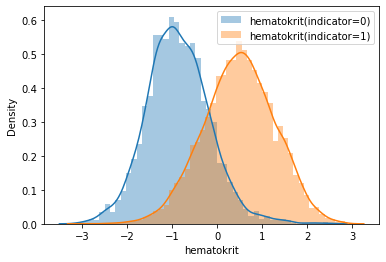

In [12]:
distributions = __distplot_visualisation__(train_dataframe, "hematokrit", "indicator", [0,1])

Znázornená distribúcia hematokritu a indikátoru, kde vidíme, že si môžeme zvoliť hranicu *-0.2*.

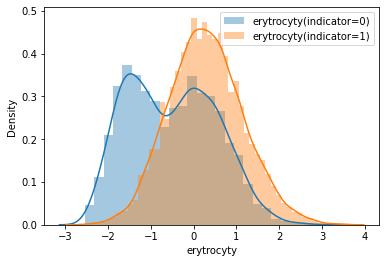

In [13]:
distributions = __distplot_visualisation__(train_dataframe, "erytrocyty", "indicator", [0,1])

Znázornená distribúcia erytrocytov a indikátoru, kde nevieme jasne určiť hranicu, ale zvolíme si ju pre testovanie *-1*.

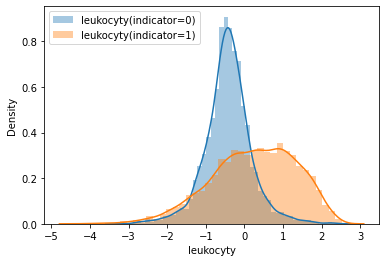

In [14]:
distributions = __distplot_visualisation__(train_dataframe, "leukocyty", "indicator", [0,1])

Znázornená distribúcia leukocytov a indikátoru, kde nevieme jasne určiť hranicu, ale zvolíme si ju pre testovanie *0.5*.

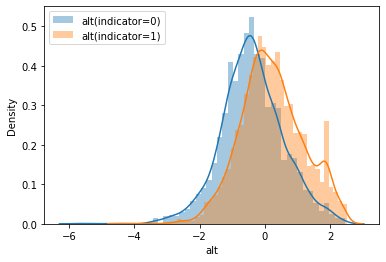

In [15]:
distributions = __distplot_visualisation__(train_dataframe, "alt", "indicator", [0,1])

Znázornená distribúcia atribútu alt a indikátoru, kde nevieme jasne určiť hranicu, ale zvolíme si ju pre testovanie *0.1*.


Number of rows:    9914
TP (True Positive) 5513
TN (True Negative) 2708
FP (False Positive) 826
FN (False Negative) 867
accuracy: (TP + TN) / total population =  0.829231389953601
precision: TP / (FP + TP) =  0.8696955355734343
recall: TP / (FN + TP) =  0.8641065830721003


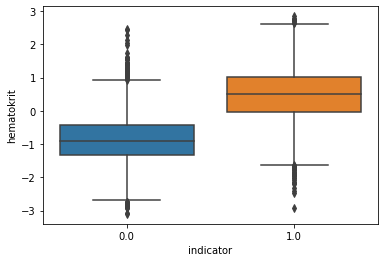

In [16]:
rules = dict()
__1R_single__(train_dataframe, "1R")

Využitie 1R algoritmu s jednou premennou implementovaného s presnosťou 87% a popis metrík, ktoré nastali počas klasifikácie.

Pearson correlation (erytrocyty, alt): 0.853

Number of rows:    9914
TP (True Positive) 2779
TN (True Negative) 2756
FP (False Positive) 778
FN (False Negative) 3601
accuracy: (TP + TN) / total population =  0.5583013919709502
precision: TP / (FP + TP) =  0.7812763564801799
recall: TP / (FN + TP) =  0.43557993730407524


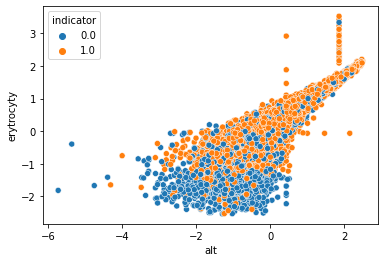

In [17]:
print("Pearson correlation (erytrocyty, alt): %.3f" % train_dataframe.erytrocyty.corr(train_dataframe.alt))
__1R_more_attributes_classificator__(train_dataframe, "more_attributes")

Využitie 1R algoritmu s dvoma premennými (kombinácia alt a erytrocyty) implementovaného s presnosťou 78% a popis metrík, ktoré nastali počas klasifikácie. Tieto atribúty boli vybrané kvôli veľkosti Pearsonovej korelácie medzi nimi. Toto bol akýsi bonus pokus, kde nám accuracy a recall nevyšiel podľa predstáv, ale po dlhšej kalibrácii by sa to dalo lepšie nastaviť.

## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia


*	Na trénovanie využite minimálne jeden stromový algoritm strojového učenia v scikit-learn.   

*	Vizualizujte natrénované pravidlá.

*	Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall.

*	Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.


In [18]:
x = train_dataframe.drop(['indicator'], axis = 1)
y = train_dataframe['indicator']

Rozdelenie datasetu z minulej fázy na x a y, aby sme mohli splitnuť na x_train a y_train pre vyhodnotenie klasifikátora.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 1)

Vytvorenie x_train a y_train pre naše testovanie takisto ako v minulej fáze, ale z preprocessed data.

In [20]:
columns = ['address']
train_labels = y_train
valid_labels = train_dataframe['indicator']

df_train_indicator = x_train.drop(columns, axis = 1)
df_train_indicator = pd.get_dummies(df_train_indicator)

df_valid_indicator = train_dataframe.drop(columns, axis = 1)
df_valid_indicator = pd.get_dummies(df_valid_indicator)

missing_cols = set( df_train_indicator.columns ) - set( df_valid_indicator.columns )

for c in missing_cols:
    df_valid_indicator[c] = 0

df_valid_indicator = df_valid_indicator[df_train_indicator.columns]

Dropneme address, pretože nakoniec to nebudeme potrebovať.

In [21]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df_train_indicator, train_labels)

Využijeme funkciu DecionTreeClassifier a fitneme naše nové vytvorené trénovacie dataframes.

In [22]:
predicted_labels = clf.predict(df_valid_indicator)
basic_acc = metrics.accuracy_score(valid_labels, predicted_labels)
basic_acc

0.9752874722614484

Predikujeme na základe pôvodného datasetu voči trénovacieho a vyšla nám basic accuracy 0.97.

In [23]:
dot_data = tree.export_graphviz(clf, out_file = None, 
                                feature_names = df_valid_indicator.columns,
                                class_names = ["1","0"], 
                                filled = True,
                                rounded = True,
                               )
graph = graphviz.Source(dot_data)
graph.render("tree");

Pomocou graphviz si vygenerujeme strom, aby sme ho mali v pdf dokumente následne lepšie čítateľný.

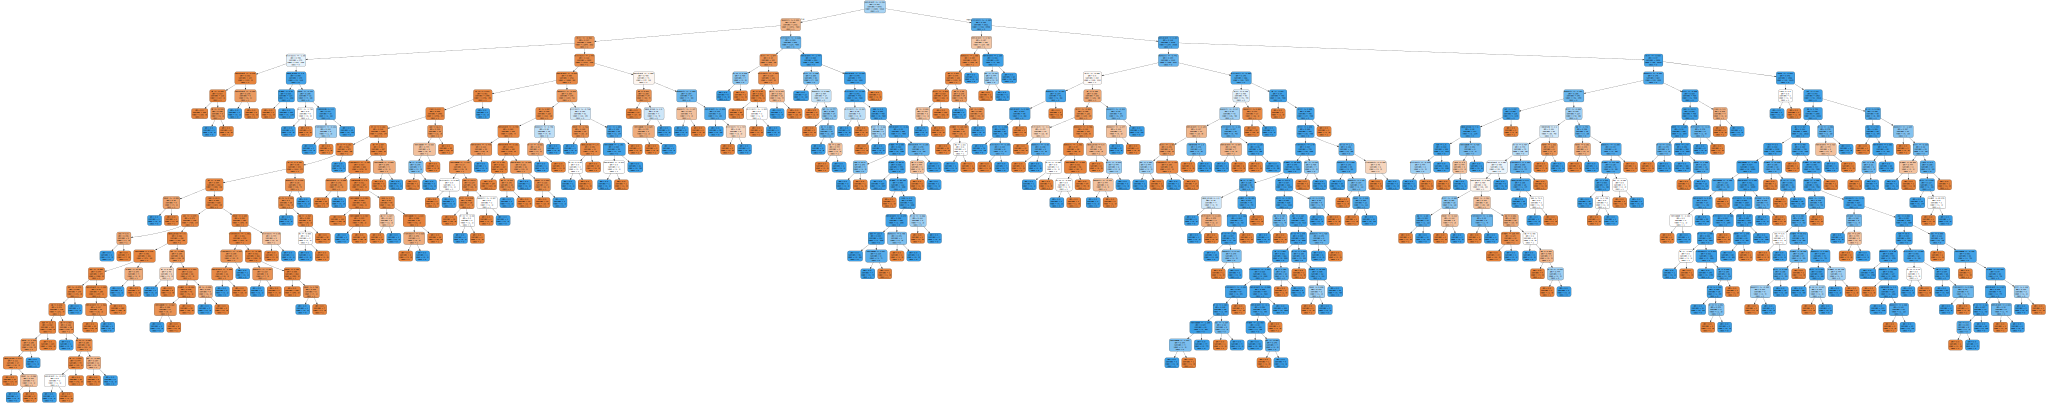

In [24]:
graph

Vízualizácia tree klasifikátora. (cez wand.image nám to obom nešlo, pretože tam bol nejaký problém s imagemagick, nad ktorým sme dlho strávili, MAC users, ale je vyexportované tree.pdf a taktiež priložené v odovzdaní)

In [25]:
print(classification_report(valid_labels, predicted_labels, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3534
           1       0.98      0.98      0.98      6380

    accuracy                           0.98      9914
   macro avg       0.97      0.97      0.97      9914
weighted avg       0.98      0.98      0.98      9914



Vyhodnotenie klasifikátora pomocou metrík precision, recall a accuracy.

[[3415  119]
 [ 126 6254]]


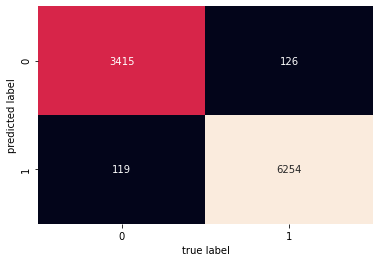

In [26]:
print(confusion_matrix(valid_labels, predicted_labels))
mat = confusion_matrix(valid_labels, predicted_labels)
sns.heatmap(mat.T, annot = True, fmt = 'd', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Confusion matrix vyobrazený pomocou heatmapy. Vidíme, že je veľmi slušný, pretože sa zmýlil iba okolo 200krát ináč tento model predikoval stále dobré hodnoty.

### Porovnanie natrénovaného a manuálne vytvoreného klasifikátora

In [27]:
print("Metriky pravidla 1R:\n\n", rules["1R"]["cr"])

Metriky pravidla 1R:

               precision    recall  f1-score   support

           0       0.76      0.77      0.76      3534
           1       0.87      0.86      0.87      6380

    accuracy                           0.83      9914
   macro avg       0.81      0.82      0.81      9914
weighted avg       0.83      0.83      0.83      9914



Súhrn vyhodnotenia prvého 1R pravidla.

In [28]:
print("Metriky pravidla 1R s viac atribútmi: \n\n", rules["more_attributes"]["cr"])

Metriky pravidla 1R s viac atribútmi: 

               precision    recall  f1-score   support

           0       0.43      0.78      0.56      3534
           1       0.78      0.44      0.56      6380

    accuracy                           0.56      9914
   macro avg       0.61      0.61      0.56      9914
weighted avg       0.66      0.56      0.56      9914



Súhrn vyhodnotenia druhého 1R pravidla.

In [29]:
print("Metriky klasifikacie pomocou rozhodovacieho stromu\n\n", classification_report(valid_labels, predicted_labels, target_names = ["0","1"]))

Metriky klasifikacie pomocou rozhodovacieho stromu

               precision    recall  f1-score   support

           0       0.96      0.97      0.97      3534
           1       0.98      0.98      0.98      6380

    accuracy                           0.98      9914
   macro avg       0.97      0.97      0.97      9914
weighted avg       0.98      0.98      0.98      9914



Vyhodnotenie importnutého tree klasifikátora, vidíme, aj ako sme predpokladali, že bude najlepší, čo sa nám potvrdilo, ale náš 1R algoritmus s prvým pravidlom sa skôr približuje k tomuto natrénovanému klasifikátoru ako 1R pre druhé pravidlo, ale nie su vôbec dokonalé, ale si myslím, ak by sme to kalibrovali troška dlhšie, tak by sa dali vyhrať krajšie výsledky.

## 3. Optimalizácia - hyperparameter tuning


*	Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok.

*	Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

In [30]:
cls2 = DecisionTreeClassifier()
model2 = cls2.fit(df_train_indicator, train_labels)

Pripravíme si tree klasifikátor pomocou 10 násobnej cross validácie a porovnáme výsledky.

In [31]:
scoring = ['accuracy','precision_macro','recall_macro']
scores = cross_validate(cls2, df_train_indicator, train_labels, scoring = scoring, cv = 10)

print("Accuracy:")
print("    Values: ", scores['test_accuracy'])
print("    Mean: ", scores['test_accuracy'].mean())
print("\nPrecision:")
print("    Values: ", scores['test_precision_macro'])
print("    Mean: ", scores['test_precision_macro'].mean())
print("\nRecall:")
print("    Values: ", scores['test_recall_macro'])
print("    Mean: ", scores['test_recall_macro'].mean())

Accuracy:
    Values:  [0.91278195 0.92180451 0.92771084 0.9186747  0.92921687 0.89909639
 0.90512048 0.92018072 0.92921687 0.9126506 ]
    Mean:  0.917645393604493

Precision:
    Values:  [0.90474047 0.91295547 0.91826087 0.90923695 0.92351166 0.89131554
 0.89580406 0.91570881 0.92287736 0.90322236]
    Mean:  0.9097633540128003

Recall:
    Values:  [0.90621133 0.91876363 0.92697361 0.91632784 0.92273197 0.88913118
 0.89933054 0.91017967 0.92364755 0.90887522]
    Mean:  0.912217253310659


Pomocou 10-násobnej cross-validácie nám vyšlo, že máme horšie výsledky ako keď sme mali iba natrénovaný model bez cross-validácie ani v jednej metrike.

In [32]:
bestRunA, bestRunP, bestRunR = __hyper_max_depth__(15)

Max-depth:  1
Accuracy:  0.8076457534799274
Precision:  0.7994172942926873
Recall:  0.8248616662497583

Max-depth:  2
Accuracy:  0.8793625176518055
Precision:  0.8713177932231959
Recall:  0.8636053172672808

Max-depth:  3
Accuracy:  0.9177930199717571
Precision:  0.9196736833946386
Recall:  0.8998386475846811

Max-depth:  4
Accuracy:  0.9376639096227557
Precision:  0.934261434748542
Recall:  0.9292885680172724

Max-depth:  5
Accuracy:  0.946035908815816
Precision:  0.9450533728727786
Recall:  0.9367399627088755

Max-depth:  6
Accuracy:  0.9509784143635264
Precision:  0.9450369549150037
Recall:  0.9486585307438887

Max-depth:  7
Accuracy:  0.9592495460964293
Precision:  0.958423930628357
Recall:  0.9524341240400019

Max-depth:  8
Accuracy:  0.9649989913253985
Precision:  0.962427701194034
Recall:  0.961192881333681

Max-depth:  9
Accuracy:  0.9685293524309058
Precision:  0.9656486291962332
Recall:  0.9657661002034867

Max-depth:  10
Accuracy:  0.9699414968731087
Precision:  0.9671872095

Pomocou funkcie __hyper_max_depth__ hľadáme najlepšiu hĺbku stromu, kde dosahujeme najlepšie metriky a podľa toho si potom vieme vybrať, do akej maximálnej hĺbky budeme strom tuningovať.

In [33]:
print("Best run accuracy: ",bestRunA)
print("Best run precision: ",bestRunP)
print("Best run recall: ",bestRunR)

Best run accuracy:  14
Best run precision:  14
Best run recall:  14


Ak sme si teraz vypísali najlepšie metriky, ktoré sme dosiahli, tak si vyberieme hĺbku 14, lebo sme tu dosiahli 2 najvyššie možné hodnoty pre metriky accuracy a precision. Max_depth teda budeme používať 14.

In [34]:
cls2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 14)
model2 = cls2.fit(df_train_indicator, train_labels)
scoring = ['accuracy','precision_macro','recall_macro']
scores = cross_validate(cls2, df_train_indicator, train_labels, scoring = scoring, cv = 10)

test = df_valid_indicator
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(valid_labels, pred))
print("Precision: ",sm.precision_score(valid_labels, pred, average = 'macro')) 
print("Recall: ",sm.recall_score(valid_labels, pred, average = 'macro')) 

Accuracy:  0.9739761952794028
Precision:  0.9704550130285527
Recall:  0.9730274911163033


Vidíme, že sme sa priblížili oproti iba cross-validácii o kúsok k lepšiemu výsledku, ďalej pôjdeme skúmať počet listov stromu.

In [35]:
bestRunA, bestRunP, bestRunR = __hyper_number_leaves__(30)

Max-depth:  2
Accuracy:  0.8076457534799274
Precision:  0.7994172942926873
Recall:  0.8248616662497583

Max-depth:  3
Accuracy:  0.8804720597135364
Precision:  0.878101747507394
Recall:  0.8579667644183773

Max-depth:  4
Accuracy:  0.9063949969739762
Precision:  0.8981011733433325
Recall:  0.8977990341918098

Max-depth:  5
Accuracy:  0.9087149485575953
Precision:  0.9133996718094075
Recall:  0.8864109599005097

Max-depth:  6
Accuracy:  0.9280815009078072
Precision:  0.9281446646240994
Recall:  0.9140174356408769

Max-depth:  7
Accuracy:  0.9269719588460763
Precision:  0.9209419504547549
Recall:  0.9196559884897804

Max-depth:  8
Accuracy:  0.9371595723219689
Precision:  0.9348467241449713
Recall:  0.9274451233250484

Max-depth:  9
Accuracy:  0.9371595723219689
Precision:  0.9348467241449713
Recall:  0.9274451233250484

Max-depth:  10
Accuracy:  0.9371595723219689
Precision:  0.9348467241449713
Recall:  0.9274451233250484

Max-depth:  11
Accuracy:  0.9371595723219689
Precision:  0.93484

Pomocou funkcie __hyper_number_leaves__ hľadáme najlepší počet listov stromu, kde dosahujeme najlepšie metriky a podľa toho si potom vieme vybrať, koľko listov stromu budeme využívať v tuningu.

In [36]:
print("Best run accuracy: ",bestRunA)
print("Best run precision: ",bestRunP)
print("Best run recall: ",bestRunR)

Best run accuracy:  29
Best run precision:  29
Best run recall:  23


Ak sme si teraz vypísali najlepšie metriky, ktoré sme dosiahli, tak si vyberieme počet listov 28, lebo sme tu dosiahli 2 najvyššie možné hodnoty pre metriky accuracy a precision. Max_leaf_nodes teda budeme používať 28.

In [37]:
cls2 = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = 28)
model2 = cls2.fit(df_train_indicator, train_labels)
scoring = ['accuracy','precision_macro','recall_macro']
scores = cross_validate(cls2, df_train_indicator, train_labels, scoring = scoring, cv = 10)

test = df_valid_indicator
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(valid_labels, pred))
print("Precision: ",sm.precision_score(valid_labels, pred, average = 'macro')) 
print("Recall: ",sm.recall_score(valid_labels, pred, average = 'macro')) 

Accuracy:  0.9554165826104498
Precision:  0.9507671890307088
Recall:  0.9522330322722572


Pri tomto parametri sme sa zhoršili so všetkými parametrami o pár stotín, ale teraz ešte skúsime spojiť tieto dva parametre.

In [38]:
cls2 = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = 28, max_depth = 14)
model2 = cls2.fit(df_train_indicator, train_labels)
scoring = ['accuracy','precision_macro','recall_macro']
scores = cross_validate(cls2, df_train_indicator, train_labels, scoring = scoring, cv = 10)

test = df_valid_indicator
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(valid_labels, pred))
print("Precision: ",sm.precision_score(valid_labels, pred, average = 'macro')) 
print("Recall: ",sm.recall_score(valid_labels, pred, average = 'macro')) 

Accuracy:  0.9554165826104498
Precision:  0.9507671890307088
Recall:  0.9522330322722572


Ukázalo sa nám, že ani pri spojení nedosiahneme lepšie výsledky, ale iba pomocou zvolenia parametru max_depth = 14.

In [39]:
runAx, runAy, runPx, runPy, runRx, runRy = __combination__(25, 20)

In [40]:
print("Depth / Nodes")
print("Best run accuracy: ",runAx, "/" ,runAy)
print("Best run precision: ",runPx, "/" ,runPy)
print("Best run recall: ",runRx, "/" ,runRy)

Depth / Nodes
Best run accuracy:  8 / 24
Best run precision:  6 / 24
Best run recall:  7 / 23


Najlepšou kombináciou podľa funkcie __combination__ nám vyšla podľa hĺbok z intervalu od 6 do 8, takŽe si môžeme vybrať napr. kde máme najlepšiu presnosť, takže hĺbku 6 a počet listov 24, a budeme pokračovať s novými hodnotami.

In [41]:
cls2 = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = 24, max_depth = 6)
model2 = cls2.fit(df_train_indicator, train_labels)
scoring = ['accuracy','precision_macro','recall_macro']
scores = cross_validate(cls2, df_train_indicator, train_labels, scoring = scoring, cv = 10)

test = df_valid_indicator
pred = cls2.predict(test)
print("Accuracy: ",sm.accuracy_score(valid_labels, pred))
print("Precision: ",sm.precision_score(valid_labels, pred, average = 'macro')) 
print("Recall: ",sm.recall_score(valid_labels, pred, average = 'macro')) 

Accuracy:  0.9481541254791205
Precision:  0.9406616445685969
Recall:  0.9476633172069622


Vidíme, že sa nám to ešte zase zhoršilo, čize najlepšie bude, ak si zvolíme pri klasifikácii iba hĺbku stromu a počet listov necháme tak.

In [42]:
cls2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 14)
model2 = cls2.fit(df_train_indicator, train_labels)
scoring = ['accuracy','precision_macro','recall_macro']
scores = cross_validate(cls2, df_train_indicator, train_labels, scoring = scoring, cv = 10)

test = df_valid_indicator
pred = cls2.predict(test)

Volíme si teda max_depth 14 a počet listov necháme tak.

In [43]:
dot_data = tree.export_graphviz(cls2, out_file = None, 
                                feature_names = df_train_indicator.columns,
                                class_names = ["1","0"], 
                                filled = True,
                                rounded = True,
                               )
graph = graphviz.Source(dot_data)
graph.render("tree_hyper")
print("Accuracy: ", sm.accuracy_score(valid_labels, pred))
print("Precision: ", sm.precision_score(valid_labels, pred, average = 'macro')) 
print("Recall: ", sm.recall_score(valid_labels, pred, average = 'macro')) 

Accuracy:  0.9746822675005044
Precision:  0.9714030857910737
Recall:  0.973576080457996


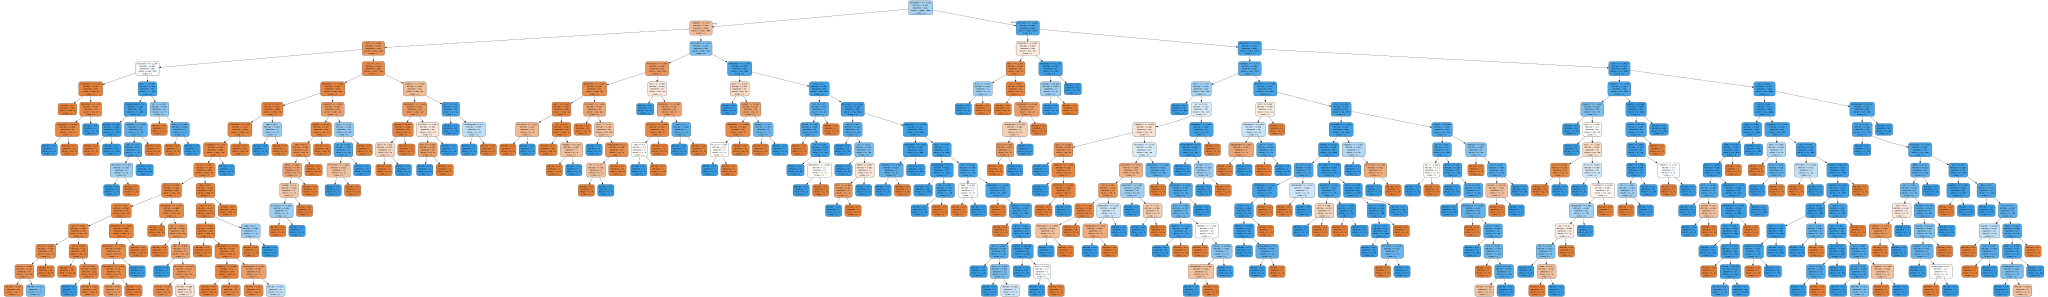

In [44]:
graph

Vizualizácia pomocoi graphiz, priložené pdfko na lepšie čítanie stromu v odovzdaní.